# EECS595 Final Project 
# Exploring LSTM Networks Approach on TRIP Dataset
# By Yingzhuo Yu

# Colab Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

DRIVE_PATH = '/content/drive/MyDrive/EECS595_FinalProject'
sys.path.append(DRIVE_PATH)

!pip install jsonlines
!pip install 'transformers==4.2.2'
!pip install sentencepiece
# !pip3 install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2
!pip install progressbar2

import torch
print(torch.cuda.is_available())

Mounted at /content/drive
     |████████████████████████████████| 1.8 MB 8.1 MB/s 
     |████████████████████████████████| 895 kB 54.6 MB/s 
     |████████████████████████████████| 2.9 MB 53.0 MB/s 
     |████████████████████████████████| 1.2 MB 8.2 MB/s 
True


# Setup

In [ ]:
from www.utils import print_dict
import json
from collections import Counter
from www.dataset.prepro import get_tiered_data, balance_labels
from www.dataset.featurize import add_bert_features_tiered, get_tensor_dataset_tiered
from collections import Counter
from www.dataset.ann import is_human
from transformers import RobertaModel
from transformers import RobertaTokenizer
from transformers import AutoConfig, AutoModel, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
import torch.nn as nn
import transformers
import progressbar
import math

seed_val = 43 # Save random seed for reproducibility
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_list = ["roberta-base","distilroberta-base","roberta-large","bert-large-cased","bert-base-cased"]
MODEL_PATH = "distilroberta-base"
print(f"=====Using {device}=====")
print(f"=====Model {MODEL_PATH}=====")

DEBUG = False          


=====Using cuda:0=====
=====Model distilroberta-base=====


# Load and Preprocess Data

In [ ]:
from getdata import getTIERED, Preprocess, TieredDataset

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

tiered_dataset = getTIERED(debug=DEBUG)
tiered_dataset = Preprocess(tiered_dataset,tokenizer,device,seq_length=25)

Train_dataset = TieredDataset(tiered_dataset["train"])
Train_dataloader = DataLoader(dataset=Train_dataset,batch_size=1)

Dev_dataset = TieredDataset(tiered_dataset["dev"])
Dev_dataloader = DataLoader(dataset=Dev_dataset ,batch_size=1)

Test_dataset = TieredDataset(tiered_dataset["test"])
Test_dataloader = DataLoader(dataset=Test_dataset,batch_size=1)

=====Getting Data[debug:False]=====
Cloze label distribution (train):
[(1, 400), (0, 399)]
Cloze label distribution (dev):
[(0, 161), (1, 161)]
Cloze label distribution (test):
[(1, 176), (0, 175)]
=====Finish Getting Data====
=====Preprocessing whole Data====
=====Finish Processing Data====


# Grid Search & Training

In [ ]:
from tiered import saveModel, loadModel

EPOCHES = 60
HIDDENDIM = [500,1000,2000,5000]
BILSTM = True #bilstm if true else lstm
LEARNINGRATE = 1e-4 #[1e-2,1e-3,1e-4,1e-5]
params = [[0.6,0.4],[0,1]]
# params = [[1,0],[0.9,0.1]]
# params = [[0.9,0.1]]
print(params)

def evaluation(tieredModel,dataloader,device):
  tieredModel.eval()
  with torch.no_grad():
    acc1 = 0
    acc2 = 0
    for Data in dataloader:
        plausible = Data['plausible']
        plausible = torch.tensor(plausible).to(device)
        conflict = Data['conflicts']
        conflict = torch.tensor(conflict).to(device)
        story_input = Data['story_input']
        pred_plausible, pred_conflict = tieredModel(story_input)
        if torch.argmax(pred_plausible).item() == plausible[0].item():
                acc1 += 1
                if torch.argmax(pred_conflict).item() == conflict[0].item():
                    acc2 += 1
    return acc1/len(dataloader), acc2/len(dataloader)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

[[0.6, 0.4], [0, 1]]


In [ ]:
#Training

import pickle
print(MODEL_PATH,"use two layers for conflicting sentences")
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from model import TieredModel

Max1 = -1
Max2 = -1
for hiddenDim in HIDDENDIM:
    print("Start Training")
    for pi, w in enumerate(params):
        max_acc1 = -1
        max_acc2 = -1
        tieredModel = TieredModel(MODEL_PATH=MODEL_PATH, lstm_hiddenDim=hiddenDim, bilstm=BILSTM) #add task
        tieredModel.to(device)
        Optimizer = AdamW(tieredModel.parameters(), lr=LEARNINGRATE)
        scheduler = get_linear_schedule_with_warmup(
            Optimizer, 
            num_warmup_steps=0, 
            num_training_steps=int(len(Train_dataloader)*EPOCHES)
        )
        loss_func = nn.CrossEntropyLoss()
        data = {}
        data["weight"] = w
        data["data"] = []
        for epoch in range(EPOCHES):
            print(f"epoch{epoch} lr{LEARNINGRATE} Weight{w} hiddDim{hiddenDim}")
            tieredModel.train()
            epoch_loss = 0
            epoch_acc1 = 0
            epoch_acc2 = 0
            bar_size = len(Train_dataloader)
            bar = progressbar.ProgressBar(max_value=bar_size, widgets=[progressbar.Bar('#', '[', ']'), ' ', progressbar.Percentage()])
            bar_idx = 0
            bar.start()
            for trainData in Train_dataloader:
                tieredModel.zero_grad()
                torch.cuda.empty_cache()
                plausible = trainData['plausible']
                plausible = torch.tensor(plausible).to(device)
                conflict = trainData['conflicts']
                conflict = torch.tensor(conflict).to(device)
                story_input = trainData['story_input']
                pred_plausible, pred_conflict = tieredModel(story_input)
                Loss = w[0]*loss_func(pred_plausible,plausible) + w[1]*loss_func(pred_conflict,conflict)
                Loss = loss_func(pred_plausible,plausible)
                Loss.backward()
                Optimizer.step()
                scheduler.step()
                epoch_loss += Loss.item()
                if torch.argmax(pred_plausible).item() == plausible[0].item():
                    epoch_acc1 += 1
                    if torch.argmax(pred_conflict).item() == conflict[0].item():
                        epoch_acc2 += 1
                bar_idx += 1
                bar.update(bar_idx)
            bar.finish()
            epoch_acc1=epoch_acc1/len(Train_dataloader)
            epoch_acc2=epoch_acc2/len(Train_dataloader)
            eval_acc1,eval_acc2 = evaluation(tieredModel,Dev_dataloader,device)
            test_acc1,test_acc2 = evaluation(tieredModel,Test_dataloader,device)
            print(f"\n=====Epoch{epoch}:=====")
            print(f"lr:{get_lr(Optimizer)}")
            print(f"acc1:{epoch_acc1}")
            print(f"acc2:{epoch_acc2}")
            print(f"loss:{epoch_loss/len(Train_dataloader)}")
            print(f"\ndev_acc1:{eval_acc1}")
            print(f"dev_acc2:{eval_acc2}")
            print(f"\ntest_acc1:{test_acc1}")
            print(f"test_acc2:{test_acc2}")
            max_acc1 = max(max_acc1,test_acc1)
            max_acc2 = max(max_acc2,test_acc2)
            data["data"].append([epoch_loss/len(Train_dataloader),[epoch_acc1,epoch_acc2],[eval_acc1,eval_acc2],[test_acc1,test_acc2]])
            Max1 = max(Max1,max_acc1)
            Max2 = max(Max2,max_acc2)
        print("Saving data to file")
        with open(f'saved_model/{MODEL_PATH}_{hiddenDim}_{w[0]}_{w[1]}_{"lstm" if not BILSTM else ""}.pkl', 'wb') as f:
            pickle.dump(data, f)
        print(f"\nWeight{w} hiddDim{hiddenDim} max_acc1 {max_acc1} max_acc2 {max_acc2}")


# Visualization

In [ ]:
import pathlib
import pickle
Data = {}

model_dir = pathlib.Path("model")
for model_file in model_dir.iterdir():
    if len(model_file.name.split(".pkl")[0].split("_")) < 5:
        continue
    model,dim,w0,w1,lstm = model_file.name.split(".pkl")[0].split("_")
    w0 = float(w0)
    w1 = float(w1)
    dim = int(dim)
    if model not in Data:
        Data[model] = {}
        Data[model][400] = {}
        Data[model][500] = {}
    if (w0,w1) not in Data[model][dim]:
        Data[model][dim][(w0,w1)]={"loss":[],"train1":[],"train2":[],"dev1":[],"dev2":[],"test1":[],"test2":[]}
    with open(model_file, 'rb') as f:
        tmp = pickle.load(f)
        Data[model][dim][(w0,w1)]["loss"] = [buffer[0] for buffer in tmp["data"]]
        Data[model][dim][(w0,w1)]["train1"] = [buffer[1][0] for buffer in tmp["data"]]
        Data[model][dim][(w0,w1)]["train2"] = [buffer[1][1] for buffer in tmp["data"]]
        Data[model][dim][(w0,w1)]["dev1"] = [buffer[2][0] for buffer in tmp["data"]]
        Data[model][dim][(w0,w1)]["dev2"] = [buffer[2][1] for buffer in tmp["data"]]
        Data[model][dim][(w0,w1)]["test1"] = [buffer[3][0] for buffer in tmp["data"]]
        Data[model][dim][(w0,w1)]["test2"] = [buffer[3][1] for buffer in tmp["data"]]
# for v1 in Data:
#     print(v1)
#     for v2 in Data[v1]:
#         print("   ",v2)
#         for v3 in Data[v1][v2]:
#             print("      ",v3)
        

Plotting distilroberta-base 400 (0.6, 0.4)


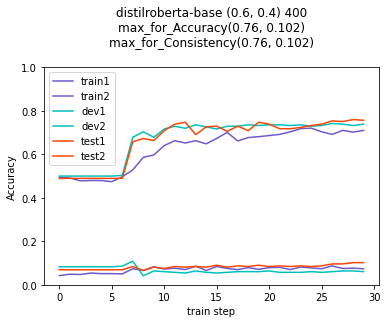

Plotting distilroberta-base 400 (0.0, 1.0)


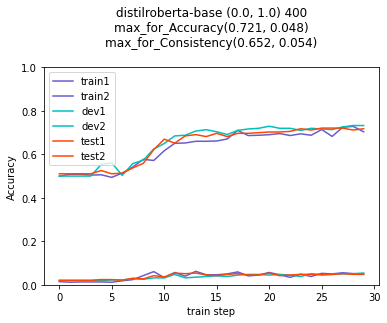

In [ ]:
import numpy as np 
from matplotlib import pyplot as plt 


def quickload(data):
    loss = np.array(data["loss"])
    train1 = np.array(data["train1"])
    train2 = np.array(data["train2"])
    dev1 = np.array(data["dev1"])
    dev2 = np.array(data["dev2"]) 
    test1 = np.array(data["test1"])
    test2 = np.array(data["test2"])
    return loss,train1,train2,dev1,dev2,test1,test2


#Experiment all cases
for model in Data:
    for dim in Data[model]:
        for weight in Data[model][dim]:
            print("Plotting",model,dim,weight)
            loss,train1,train2,dev1,dev2,test1,test2 = quickload(Data[model][dim][weight])
            i_best = [0,0]
            acc1 = -1
            acc2 = -1
            for i in range(len(loss)):
                if test1[i] > acc1:
                    acc1 = test1[i]
                    i_best[0] = i
                if test2[i] > acc2:
                    acc2 = test2[i]
                    i_best[1] = i
            x = np.array(range(len(loss)))
            figname = f"{model} {weight} {dim}"
            title = figname + f"\nmax_for_Accuracy{round(test1[i_best[0]],3),round(test2[i_best[0]],3)}\n"
            title += f"max_for_Consistency{round(test1[i_best[1]],3),round(test2[i_best[1]],3)}\n"
            plt.title(title)
            plt.xlabel("train step")
            plt.ylabel("Accuracy")
            plt.ylim((0,1))
            plt.plot(x,train1,color='slateblue',label="train1")
            plt.plot(x,train2,color='slateblue',label="train2")
            plt.plot(x,dev1,color='c',label="dev1")
            plt.plot(x,dev2,color='c',label="dev2")
            plt.plot(x,test1,color='orangered',label="test1")
            plt.plot(x,test2,color='orangered',label="test2")
            plt.legend(loc = "best")
            plt.savefig(f"plot/Experiment_{model}_{dim}_{str(weight[0]).replace('.','')}_{str(weight[1]).replace('.','')}_lstm.jpg",bbox_inches='tight')
            plt.show()
        
